In [1]:
import numpy as np
from pathlib import Path
from cached_path import cached_path

from olmo.config import TrainConfig
from olmo.data import build_memmap_dataset, DataCollator, IterableDataset
from torch.utils.data import DataLoader, DistributedSampler

import torch.distributed as dist
dist.init_process_group(backend="gloo", world_size=1, rank=0, store=dist.HashStore())

In [2]:
train_config_path = "configs/mitchish7-s3.yaml"
train_config = TrainConfig.load(train_config_path, ["global_train_batch_size=1024"])
cfg = train_config

# Fill some configuration options.
cfg.model.precision = cfg.precision
cfg.device_train_batch_size = cfg.global_train_batch_size // 1
assert cfg.device_train_batch_size is not None  # for mypy
cfg.device_train_grad_accum = cfg.device_train_batch_size // cfg.device_train_microbatch_size
if cfg.optimizer.no_decay_norm_and_bias is not None:
    log.warning(
        "You set the deprecated config option `no_decay_norm_and_bias`. For compatibility, this"
        "setting will take precedence over all other weight decay configurations. Please change"
        "your config to use `decay_norm_and_bias` and `decay_embeddings` instead."
    )
    cfg.optimizer.decay_norm_and_bias = not cfg.optimizer.no_decay_norm_and_bias
    cfg.optimizer.decay_embeddings = not cfg.optimizer.no_decay_norm_and_bias
    cfg.optimizer.no_decay_norm_and_bias = None  # So nobody uses this by accident.

# overrides because we have only one process here
train_config.data.num_workers = 4
train_config.data.pin_memory = False
train_config.data.prefetch_factor = 128

# replace all the paths with local paths
train_config.data.paths = [
    p.replace("s3://", "/mnt/tank/") for p in train_config.data.paths
]

In [3]:
collator = DataCollator(
    pad_direction=train_config.data.pad_direction,
    pad_token_id=train_config.model.pad_token_id
)
dataset = build_memmap_dataset(train_config, train_config.data, include_instance_metadata=False)
seed = train_config.data.seed if train_config.data.seed is not None else train_config.seed
work_dir = Path("./temp-work-dir")
loader = DataLoader(
        IterableDataset(
            dataset,  # type: ignore
            train_config.global_train_batch_size,
            seed=seed + (train_config.epoch or 0),
            shuffle=True,
            drop_last=train_config.data.drop_last,
            work_dir=None,
        ),
        batch_size=train_config.device_train_batch_size,
        drop_last=train_config.data.drop_last,
        collate_fn=collator,
        num_workers=train_config.data.num_workers,
        pin_memory=train_config.data.pin_memory,
        prefetch_factor=None if train_config.data.num_workers == 0 else train_config.data.prefetch_factor,
        persistent_workers=False if train_config.data.num_workers == 0 else train_config.data.persistent_workers,
        timeout=train_config.data.timeout,
    )
batches = iter(loader)

In [4]:
max_step = len(dataset) // train_config.device_train_batch_size

In [5]:
(max_step, cfg.model.vocab_size)

(408923, 50280)

In [28]:
import torch
from tqdm.notebook import trange, tqdm

total_counts = np.memmap(
    "/mnt/tank/token_counts_per_step_xxx.npy",
    dtype=np.int32,
    mode='w+',
    shape=(max_step, cfg.model.vocab_size)
)

#max_step = 1000 # DEBUG

for step, batch in tqdm(enumerate(batches), total=max_step):
    if step > max_step:
        break
    uniques, counts = batch['input_ids'].flatten().unique(return_counts=True)
    total_counts[step, uniques.numpy()] += counts.numpy()

total_counts.flush()

  0%|          | 0/408923 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
total_counts2 = np.memmap(
    "/mnt/tank/token_counts_per_step.npy",
    dtype=np.int32,
    mode='r',
    shape=(max_step, cfg.model.vocab_size)
)

In [48]:
# find some stats about the most frequent token
token_sums = total_counts2.sum(axis=0, dtype=np.int64)
max_token_count = token_sums.max()
max_token_fraction = max_token_count / token_sums.sum()
max_token_id = token_sums.argmax()
(max_token_count, max_token_fraction, max_token_id)

(63830348517, 0.03721566406629284, 15)

In [49]:
# find the mean time between tokens
time_between_tokens = np.zeros(cfg.model.vocab_size, dtype=np.int32)
times_seen = np.zeros(cfg.model.vocab_size, dtype=np.int32)
last_seen = np.full(cfg.model.vocab_size, -1, dtype=np.int32)

from tqdm.notebook import trange, tqdm

for step, token_counts in enumerate(tqdm(total_counts2)):
    token_ids_seen = token_counts.nonzero()[0]
    time_between_tokens[token_ids_seen] += step - last_seen[token_ids_seen]
    times_seen[token_ids_seen] += 1
    last_seen[token_ids_seen] = step

mean_time_between_tokens = time_between_tokens / times_seen

  0%|          | 0/408923 [00:00<?, ?it/s]

/tmp/ipykernel_131596/1294462617.py:14: RuntimeWarning: invalid value encountered in divide
  mean_time_between_tokens = time_between_tokens / times_seen


In [63]:
# for every batch, find out how long it's been since we saw that token

from tqdm.notebook import trange, tqdm

token_age = np.zeros((max_step + 1, cfg.model.vocab_size), dtype=np.int32)
batch_staleness = np.zeros(max_step, dtype=np.float64)
staleness_n = 10  # oldest n tokens are considered

for step, token_counts in enumerate(tqdm(total_counts2)):
    token_ids_seen = token_counts.nonzero()[0]

    token_ages_this_step = token_age[step, token_ids_seen]
    batch_staleness[step] = token_ages_this_step[np.argsort(token_ages_this_step)[-staleness_n:]].astype(np.float64).mean()
    
    token_age[step + 1] = token_age[step] + 1
    token_age[step + 1, token_ids_seen] = 1

batch_staleness

  0%|          | 0/408923 [00:00<?, ?it/s]

array([ 0. ,  1. ,  2. , ..., 30.1, 42.1, 37. ])

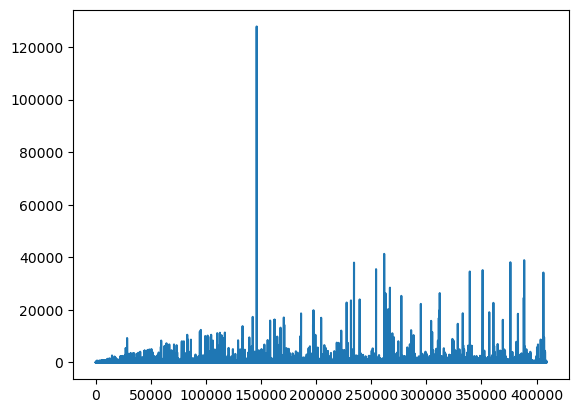

In [64]:
import matplotlib.pyplot as plt
plt.plot(batch_staleness)

In [13]:
import wandb
from typing import *
from tqdm.notebook import trange, tqdm

losses: Dict[int, float] = {}
loss_key = "train/CrossEntropyLoss"
grad_norms: Dict[int, float] = {}
grad_norm_key = "optim/total_grad_norm"

wandb_project = "olmo-medium"
wandb_group = "mitchish7"
api = wandb.Api()
runs = api.runs(f"ai2-llm/{wandb_project}", filters={"group": wandb_group}, order="created_at")
for run in tqdm(runs):
    if run.state == "running":
        continue
    for data in tqdm(run.scan_history(keys=["_step", loss_key], page_size=10000)):
        step = int(data["_step"])
        loss = data[loss_key]
        if loss is not None:
            losses[step] = loss
    for data in tqdm(run.scan_history(keys=["_step", grad_norm_key], page_size=10000)):
        step = int(data["_step"])
        grad_norm = data[grad_norm_key]
        if grad_norm is not None:
            grad_norms[step] = grad_norm

(losses, grad_norms)

  0%|          | 0/28 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

({548451: 2.0782907009124756,
  548452: 2.0691723823547363,
  548453: 2.1244990825653076,
  548454: 2.108739137649536,
  548455: 2.127166509628296,
  548456: 2.1670401096343994,
  548457: 2.151280164718628,
  548458: 2.133458375930786,
  548459: 2.096452474594116,
  548460: 2.1298599243164062,
  548461: 2.1257171630859375,
  548462: 2.110805034637451,
  548463: 2.099071502685547,
  548464: 2.0681395530700684,
  548465: 2.0737192630767822,
  548466: 2.1044058799743652,
  548467: 2.094367265701294,
  548468: 2.098543882369995,
  548469: 2.090421438217163,
  548470: 2.0892276763916016,
  548471: 2.10258150100708,
  548472: 2.0890815258026123,
  548473: 2.0552825927734375,
  548474: 2.074007749557495,
  548475: 2.054173469543457,
  548476: 2.0953710079193115,
  548477: 2.083857774734497,
  548478: 2.1459245681762695,
  548479: 2.063671588897705,
  548480: 2.114819288253784,
  548481: 2.0716359615325928,
  548482: 2.0994174480438232,
  548483: 2.0768377780914307,
  548484: 2.068228006362915

In [14]:
assert set(range(min(losses.keys()), max(losses.keys()) + 1)) == set(losses.keys())
assert min(losses.keys()) == 1

losses_np = np.zeros(len(losses), dtype=np.float64)
for i, l in losses.items():
    losses_np[i - 1] = l

losses_np.shape

(561043,)

In [47]:
grad_norms_np = np.zeros(len(grad_norms), dtype=np.float64)
grad_norms_steps = np.zeros(len(grad_norms), dtype=np.int32)
for i, (step, grad_norm) in enumerate(sorted(grad_norms.items())):
    grad_norms_np[i] = grad_norm
    grad_norms_steps[i] = step

np.save("/mnt/tank/grad_norms.npy", grad_norms_np)
np.save("/mnt/tank/grad_norms_steps.npy", grad_norms_steps)

In [19]:
np.save("/mnt/tank/losses.npy", losses_np)

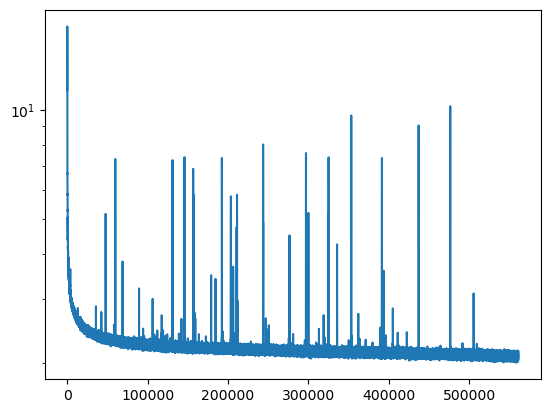

In [15]:
import matplotlib.pyplot as plt
plt.semilogy(losses_np)

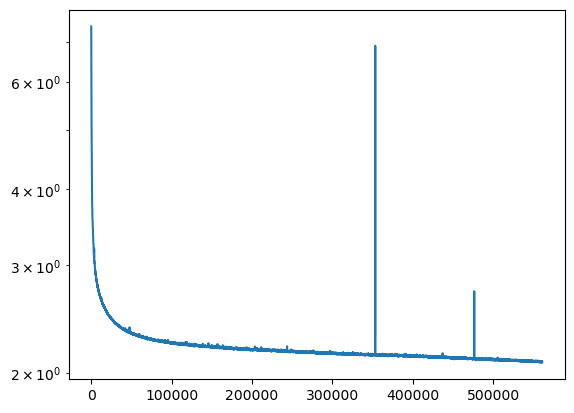

In [16]:
losses_without_spikes = np.lib.stride_tricks.sliding_window_view(losses_np, 128)
losses_without_spikes = np.median(losses_without_spikes, axis=-1)
plt.semilogy(losses_without_spikes)

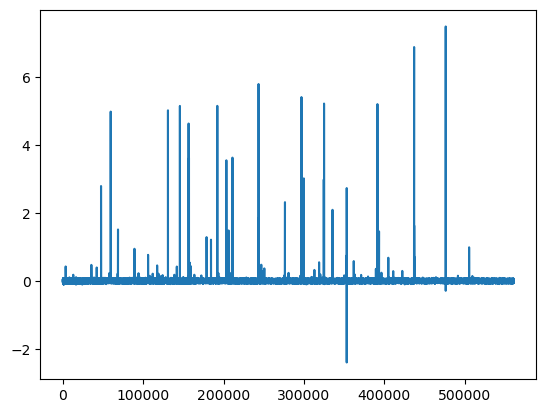

In [17]:
extra_values = losses_np.shape[0] - losses_without_spikes.shape[0]
values_left = extra_values // 2
values_right = extra_values - values_left
assert losses_np[values_left:-values_right].shape == losses_without_spikes.shape
deviations_from_the_median = losses_np[values_left:-values_right] - losses_without_spikes
plt.plot(deviations_from_the_median)

In [67]:
(batch_staleness.shape, deviations_from_the_median.shape)

((408923,), (560916,))

In [68]:
batch_staleness.max()

127824.9

/tmp/ipykernel_135641/364746217.py:5: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(xs), np.log(ys))
/tmp/ipykernel_135641/364746217.py:5: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(xs), np.log(ys))


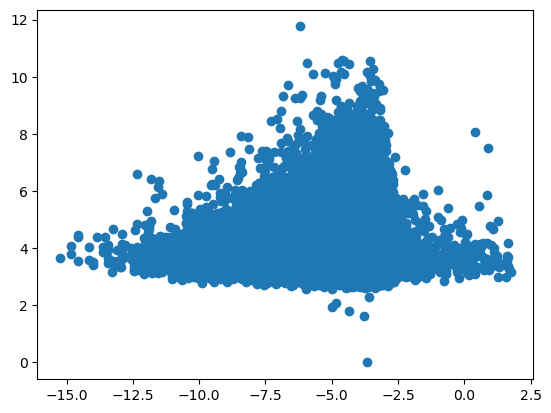

In [70]:
ys = batch_staleness
offset = 0
xs = deviations_from_the_median[values_left + offset : ys.shape[0] + values_left + offset]

plt.scatter(np.log(xs), np.log(ys))

/tmp/ipykernel_135641/1060031173.py:10: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(xs), ys)


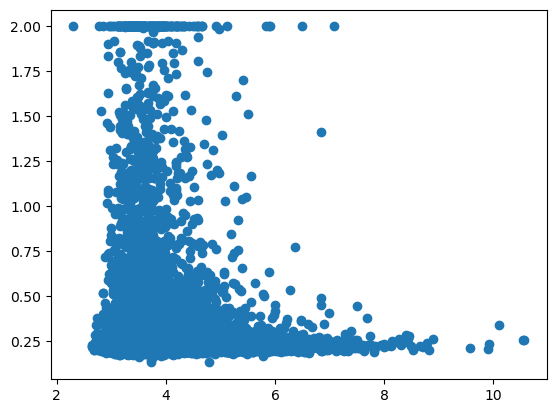

In [66]:
# try it with grad norm instead

ys = np.clip(grad_norms_np, 0, 2)
xs = np.zeros_like(ys)
for i, step in enumerate(grad_norms_steps):
    if step > len(batch_staleness):
        break
    xs[i] = batch_staleness[step]

plt.scatter(np.log(xs), ys)